In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
from palmerpenguins import load_penguins

## Chapter 3

In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [5]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [6]:
# prior predictive check --> mu and sigma
prior_samples = Predictive(
    model_prior, {}, num_samples=1000, return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (146). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4fcac23a0>]],
      dtype=object)

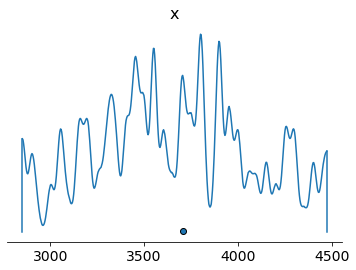

In [7]:
az.plot_density(data=prior_samples['mass'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4fd25d3a0>]],
      dtype=object)

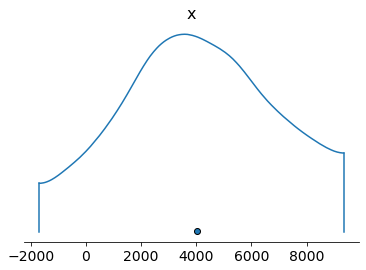

In [8]:
az.plot_density(data=prior_samples['mu'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4fd2b9670>]],
      dtype=object)

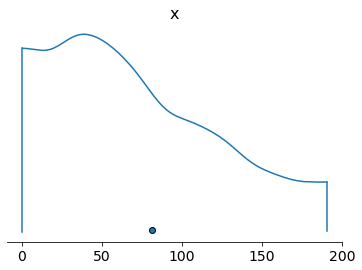

In [9]:
az.plot_density(data=prior_samples['sigma'].numpy())

In [15]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [16]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(obs=adelie_mass_obs)

Sample: 100%|██████████| 3000/3000 [00:41, 73.16it/s, step size=9.01e-01, acc. prob=0.908] 


In [17]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu   3705.42     35.12   3705.16   3650.32   3766.13   1848.79      1.00
     sigma    433.88     22.64    432.78    396.69    470.26   2123.61      1.00

Number of divergences: 0


In [18]:
samples_1 = mcmc.get_samples()

In [19]:
samples_1

{'mu': tensor([3672.0374, 3746.8244, 3655.5182,  ..., 3720.1444, 3701.9318,
         3701.9318], dtype=torch.float64),
 'sigma': tensor([443.9074, 429.9802, 417.7627,  ..., 464.2077, 431.8741, 431.8741],
        dtype=torch.float64)}

## 3.2.1 - Linear Penguins

In [20]:
adelie_flipper_length = torch.from_numpy(penguins.loc[adelie_mask, 'flipper_length_mm'].values)
adelie_mass = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

In [94]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

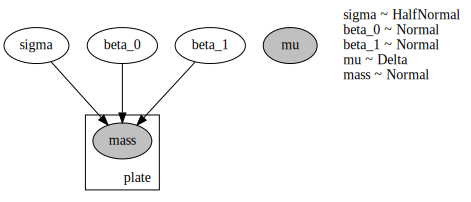

In [28]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, adelie_mass),
    render_distributions=True
    )

### MCMC

- `mcmc` = fitted MCMC object
- `mcmc_samples` = only the latent variables are returned via the `.get_samples()` method
    - `mu` is not returned in the `mcmc.get_samples()` dict
    - deterministic parts are only available via the `Predictive` function. Similarily, observed samples is only available via this function too 

In [30]:
kernel = NUTS(linear_model)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=100)
mcmc.run(flipper_length=adelie_flipper_length, mass=adelie_mass)

Sample: 100%|██████████| 600/600 [03:30,  2.85it/s, step size=2.99e-02, acc. prob=0.944]


In [31]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0  -2245.65    897.68  -2231.07  -3592.09   -825.16     70.18      1.00
    beta_1     31.33      4.72     31.30     23.92     38.53     70.33      1.00
     sigma    391.13     21.18    390.34    358.00    427.44    364.21      1.00

Number of divergences: 0


In [95]:
# latent variables
mcmc_samples = mcmc.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# latent variables: 
mass_samples = predictive(flipper_length=adelie_flipper_length, mass=adelie_mass) 

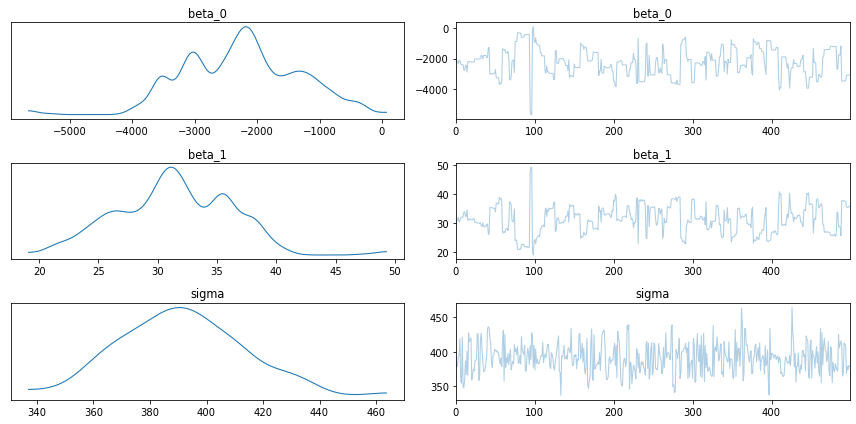

In [149]:
# trace plots looks horrible --> scale variable
az.plot_trace(az.from_pyro(mcmc))
plt.tight_layout()

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


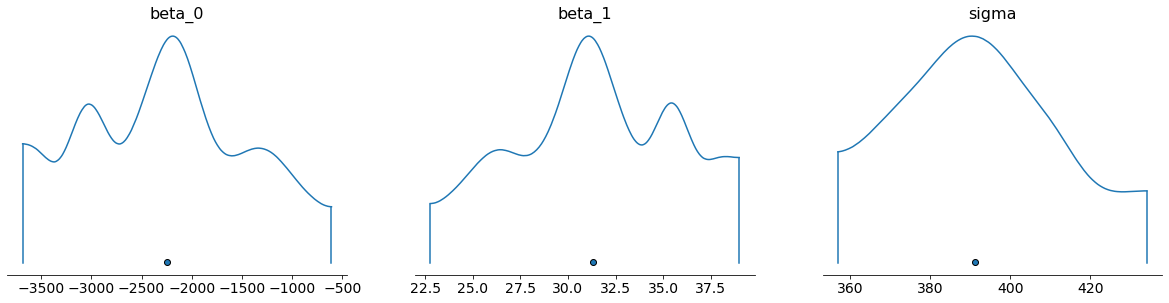

In [96]:
az_data = az.from_pyro(posterior=mcmc, posterior_predictive=mcmc_samples)
az.plot_density(data=az_data)
plt.show()

#### Posterior Predictive Distribution

Compute sampled mass and mu. This is the posterior predictive distribution.

In [ ]:
posterior_predictive = Predictive(linear_model, mcmc_samples)
posterior_samples = posterior_predictive(adelie_flipper_length, adelie_mass_obs)
for k, v in predictive.items():
    print(f'{k}: {tuple(v.shape)}')

# or 
#posterior_predictive = Predictive(linear_model, mcmc_samples)(adelie_flipper_length, None)

In [89]:
def mcmc_fit(predictive):
    mass = predictive['mass']
    mass_mu = mass.mean(axis=0)
    mass_std = mass.std(axis=0)

    mass_df = pd.DataFrame({
        'feat': adelie_flipper_length,
        'mean': mass_mu,
        'high': mass_mu + mass_std,
        'low': mass_mu - mass_std}
    )

    return mass_df.sort_values(by=['feat'])

In [ ]:
mass_df = mcmc_fit(predictive=predictive)
mass_df

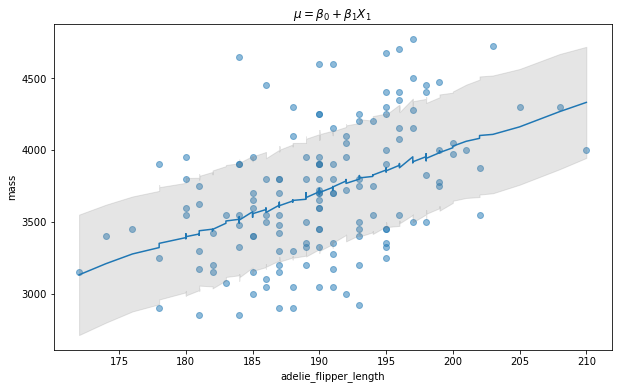

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), adelie_mass.numpy(), alpha=0.5)
plt.plot(mass_df['feat'], mass_df['mean'])
plt.fill_between(
    mass_df['feat'], mass_df['high'], mass_df['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

### Stochastic Variational Inference (SVI)

Using SVI for a simple linear regression like this is probably overkill, but lets do it anyways.

For the surrogate, we use the predefined `AutoNormal`

In [ ]:
def model(features, counts):
    N, P = features.shape

    scale = pyro.sample("scale", dist.LogNormal(0, 1))
    coef = pyro.sample("coef", dist.Normal(0, scale).expand([P]).to_event(1))

    rate = pyro.deterministic("rate", torch.nn.functional.softplus(coef @ features.T))

    concentration = pyro.sample("concentration", dist.LogNormal(0, 1))
    
    with pyro.plate("bins", N):
        return pyro.sample("counts", dist.GammaPoisson(concentration, rate), obs=counts)

In [ ]:
def guide(features, counts):
    N, P = features.shape

    scale_param = pyro.param("scale_param", torch.tensor(0.1), constraint=constraints.positive)
    loc_param = pyro.param("loc_param", torch.tensor(0.0))
    
    scale = pyro.sample("scale", dist.Delta(scale_param))
    coef = pyro.sample("coef", dist.Normal(loc_param, scale).expand([P]).to_event(1))

    concentration_param = pyro.param("concentration_param", torch.tensor(0.1), constraint=constraints.positive)
    concentration = pyro.sample("concentration", dist.Delta(concentration_param))

In [ ]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

In [147]:
def guide(flipper_length, mass=None):

    sigma_loc = pyro.param(
        'sigma_loc', lambda: torch.tensor(1.), constraint=constraints.positive)

    beta_0_loc = pyro.param(
        'beta_0_loc', lambda: torch.tensor(0.))
    beta_0_scale = pyro.param(
        'beta_0_scale', lambda: torch.tensor(1.), constraint=constraints.positive)

    beta_1_loc = pyro.param('beta_1_loc', lambda: torch.randn(1))
    beta_1_scale = pyro.param(
        'beta_1_scale', lambda: torch.ones(1), constraint=constraints.positive)
    

    sigma = pyro.sample('sigma', dist.HalfNormal(sigma_loc, torch.tensor(0.05)))
    beta_0 = pyro.sample('beta_0', dist.Normal(beta_0_loc, beta_0_scale))
    beta_1 = pyro.sample('beta_1', dist.Normal(beta_1_loc, beta_1_scale))

    return {'beta_0': beta_0, 'beta_1': beta_1, 'sigma': sigma}

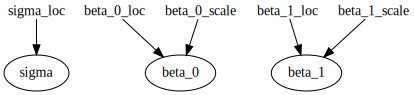

In [136]:
pyro.render_model(
    guide, 
    model_args=(adelie_flipper_length, adelie_mass_obs), 
    render_params=True
    )

In [145]:
custom_guide = guide(linear_model)
custom_guide

{'beta_0': tensor(1.3285, grad_fn=<AddBackward0>),
 'beta_1': tensor([-0.1940], grad_fn=<AddBackward0>),
 'sigma': tensor(1.8919, grad_fn=<AbsBackward0>)}

In [146]:
auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
auto_guide

AutoNormal()

In [ ]:
pyro.clear_param_store()

# These should be reset each training loop
#auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
adam = pyro.optim.Adam({'lr': 0.005})
elbo = pyro.infer.Trace_ELBO()
svi = SVI(linear_model, custom_guide, adam, elbo)

losses = []
for step in range(2001): 
    loss = svi.step(adelie_flipper_length, adelie_mass)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

pyro.get_param_store() is comprised of learned parameters that will be used in the `Predictive` stage. Instead of providing samples, the `guide` parameter is used to construct the posterior predictive distribution

In [127]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

sigma_loc tensor(1.8268, grad_fn=<AddBackward0>)
beta_0_loc tensor(0.6123, requires_grad=True)
beta_0_scale tensor(1.0407, grad_fn=<AddBackward0>)
beta_1_loc tensor(1.6124, requires_grad=True)
beta_1_scale tensor(1.2431, grad_fn=<AddBackward0>)


In [115]:
auto_guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([8.8762, 9.3293, 9.8056]),
 'beta_0': tensor([2.2751, 2.3356, 2.3961]),
 'beta_1': tensor([2.2702, 2.3357, 2.4011])}

In [116]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
        
    return site_stats

In [117]:
predictive = Predictive(linear_model, guide=auto_guide, num_samples=1000)
svi_samples = predictive(adelie_flipper_length, mass=None)
svi_mass = svi_samples['mass']

In [118]:
mcmc_fit(predictive=svi_samples)

,feat,mean,high,low
23,172.0,403.012126,422.143577,383.880675
15,174.0,407.299936,426.591326,388.008546
116,176.0,412.335914,431.556300,393.115527
26,178.0,416.982931,436.613824,397.352038
25,178.0,416.946930,436.484786,397.409073
...,...,...,...,...
84,202.0,473.054658,494.414434,451.694883
95,203.0,474.969175,496.827738,453.110611
85,205.0,480.014441,501.593613,458.435269
89,208.0,486.682193,508.355992,465.008395


In [105]:
svi_samples

{'sigma': tensor([[ 901.4836],
         [ 935.9409],
         [ 863.8295],
         [ 917.8823],
         [ 831.7776],
         [ 868.6370],
         [ 920.8401],
         [ 907.6031],
         [ 909.4552],
         [ 848.1215],
         [ 913.5342],
         [ 912.8240],
         [ 917.9186],
         [ 941.8145],
         [1053.3297],
         [ 860.3375],
         [ 856.8289],
         [ 881.7651],
         [ 952.7582],
         [ 933.2638],
         [ 980.3713],
         [ 775.0085],
         [ 852.5439],
         [ 963.7243],
         [ 911.1072],
         [ 842.8779],
         [ 915.5594],
         [ 867.3647],
         [ 947.1942],
         [ 982.2570],
         [ 916.3692],
         [1042.9774],
         [ 890.0549],
         [ 914.7674],
         [ 925.6559],
         [ 913.9390],
         [ 968.9884],
         [ 843.8173],
         [ 853.5922],
         [ 837.9808],
         [ 948.0239],
         [ 745.7980],
         [ 986.6146],
         [ 954.0898],
         [ 831.8331],
 

In [72]:
svi_mass.mean(axis=0)

tensor([1242.0074, 1275.8598, 1336.7920, 1323.1559, 1303.1278, 1242.1568,
        1337.3888, 1248.3637, 1309.7307, 1358.0897, 1268.7564, 1337.0960,
        1350.7755, 1261.7598, 1330.3260, 1194.4432, 1234.7637, 1296.8035,
        1269.1001, 1234.7471, 1282.7240, 1255.5281, 1282.7598, 1180.3519,
        1235.0948, 1221.2280, 1221.3808, 1289.3760, 1261.7452, 1337.2317,
        1343.7161, 1303.2241, 1235.3726, 1241.9845, 1262.0869, 1248.2503,
        1337.2717, 1275.9561, 1343.5958, 1268.8667, 1303.0456, 1248.2070,
        1303.2777, 1309.2499, 1275.5974, 1289.4677, 1302.9354, 1371.2758,
        1281.8484, 1309.9783, 1276.8143, 1323.1661, 1241.6840, 1330.6642,
        1268.5615, 1337.0438, 1268.5770, 1317.1812, 1261.9412, 1317.0511,
        1337.6250, 1289.1265, 1303.0116, 1358.2143, 1303.7823, 1303.2061,
        1344.5867, 1350.7935, 1302.6753, 1337.6643, 1310.0205, 1262.4296,
        1282.3934, 1336.8852, 1296.7465, 1344.1981, 1282.6227, 1324.2223,
        1310.4895, 1330.0141, 1302.673

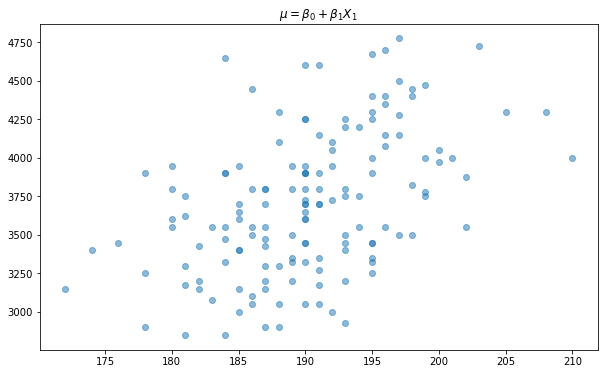

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), np.exp(adelie_mass.numpy()), alpha=0.5)
#plt.plot(adelie_flipper_length.numpy(), svi_mass.mean(axis=0))
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()